In [43]:
import sys
sys.path.insert(0, '..')
from eda_import import *

In [40]:
# to generate the same figure, version may matter.
# As I experienced, sklearn-0.19.1 may generate much larger tsne coordinates for some reason.
sklearn.__version__

'0.18'

In [2]:
%time 
TOTAL_NUM_CALLS = 67544140
_cols = ['analysis_id', 'barcode', 'disease', 'sstype', 'mkid', 'seqname', 'gene_name',
         'strand', 'participant_id', 'mclv', 'aclv']
adf = pd.read_csv('../__results/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz',
                  compression='gzip', usecols=_cols)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [3]:
# there are redundancy after clustering, thus dedup
%time bdf = adf.drop_duplicates()

CPU times: user 2.88 s, sys: 127 ms, total: 3.01 s
Wall time: 3 s


In [4]:
assert bdf.shape[0] == 2213818

In [5]:
assert bdf.mkid.unique().shape[0] == 2136

In [6]:
clusterable = ['BRCA', 'COAD', 'ESCA', 'GBM', 'HNSC',
               'KIRC', 'LAML', 'LGG', 'LIHC', 'LUSC', 'OV',
               'PCPG', 'PRAD', 'SKCM', 'STAD', 'TGCT', 'THCA']
assert len(clusterable) == 17

In [7]:
rdf = bdf.query('disease in {0}'.format(clusterable)).query('sstype == "tumour"')

In [8]:
assert rdf.analysis_id.unique().shape[0] == 7105

In [9]:
assert rdf.shape == (1477886, 11)

In [10]:
print('{0:.3%} data remained'.format(rdf.shape[0] / float(TOTAL_NUM_CALLS)))

2.188% data remained


In [11]:
rdf.gene_name.unique().shape

(114,)

In [12]:
# rdf.seqname.unique().shape

In [13]:
assert rdf.mkid.unique().shape[0] == 2014

In [14]:
disease_le = LabelEncoder()
disease_le.fit(rdf.disease.unique())

LabelEncoder()

In [15]:
disease_le.classes_

array(['BRCA', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRC', 'LAML', 'LGG',
       'LIHC', 'LUSC', 'OV', 'PCPG', 'PRAD', 'SKCM', 'STAD', 'TGCT', 'THCA'], dtype=object)

In [16]:
print(len(disease_le.classes_))

17


In [17]:
rdf['disease_enc'] = disease_le.transform(rdf.disease)

In [18]:
sdf = rdf.copy()

In [19]:
sdf.shape

(1477886, 12)

In [20]:
mkid_le = LabelEncoder()
mkid_le.fit(sdf.mkid.unique())
print(mkid_le.classes_.shape)
sdf['mkid_enc'] = mkid_le.transform(sdf.mkid)

(2014,)


Create OneHotEncoder for mkid

In [21]:
enc = OneHotEncoder()
enc.fit(sdf.mkid_enc.values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [22]:
grped = sdf.groupby(['participant_id', 'sstype', 'analysis_id'])

In [23]:
X_list = []
y_list = []
for k, g in grped:
    X_list.append(enc.transform(g.mkid_enc.values.reshape(-1, 1)).sum(axis=0))
    vals = g.disease_enc.unique()
    assert vals.shape[0] == 1
    y = vals[0]
    y_list.append(y)

In [24]:
X = np.vstack(X_list)

In [25]:
X.shape

(7105, 2014)

In [26]:
y = np.array(y_list)

In [27]:
y.shape

(7105,)

In [28]:
uniq_y = np.unique(y)
dd = dict(zip(uniq_y, disease_le.inverse_transform(uniq_y)))
pd.Series(y).value_counts().to_frame().merge(
    pd.DataFrame.from_dict(dd, orient='index'),
    left_index=True, right_index=True).sort_values('0_x').iloc[::-1].T

,0,5,7,4,16,12,9,13,10,14,8,1,2,11,3,15,6
0_x,1142,539,534,522,513,506,504,472,429,412,374,313,185,184,170,156,150
0_y,BRCA,KIRC,LGG,HNSC,THCA,PRAD,LUSC,SKCM,OV,STAD,LIHC,COAD,ESCA,PCPG,GBM,TGCT,LAML


In [29]:
%time X_reduced = TruncatedSVD(n_components=50, algorithm='arpack', random_state=0).fit_transform(X)

CPU times: user 2min 7s, sys: 3.8 s, total: 2min 11s
Wall time: 2.22 s


In [30]:
X_reduced.shape

(7105, 50)

In [31]:
random_state = np.random.randint(0, 1e9)
random_state = 188130964

In [32]:
%%time
print('random_state: {0}'.format(random_state))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate=1000, 
                  random_state=random_state, verbose=True).fit_transform(X_reduced)
df_embedded = pd.DataFrame(X_embedded)
df_embedded['y'] = y

random_state: 188130964
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7105
[t-SNE] Computed conditional probabilities for sample 2000 / 7105
[t-SNE] Computed conditional probabilities for sample 3000 / 7105
[t-SNE] Computed conditional probabilities for sample 4000 / 7105
[t-SNE] Computed conditional probabilities for sample 5000 / 7105
[t-SNE] Computed conditional probabilities for sample 6000 / 7105
[t-SNE] Computed conditional probabilities for sample 7000 / 7105
[t-SNE] Computed conditional probabilities for sample 7105 / 7105
[t-SNE] Mean sigma: 1.318042
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.252351
[t-SNE] Error after 175 iterations: 1.252351
CPU times: user 1min 49s, sys: 17.4 s, total: 2min 6s
Wall time: 1min 45s


In [33]:
df_embedded['y'] = y
df_embedded['disease'] = df_embedded.y.apply(lambda x: disease_le.inverse_transform(x))

In [35]:
df_embedded.disease.unique().shape

(17,)

In [37]:
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

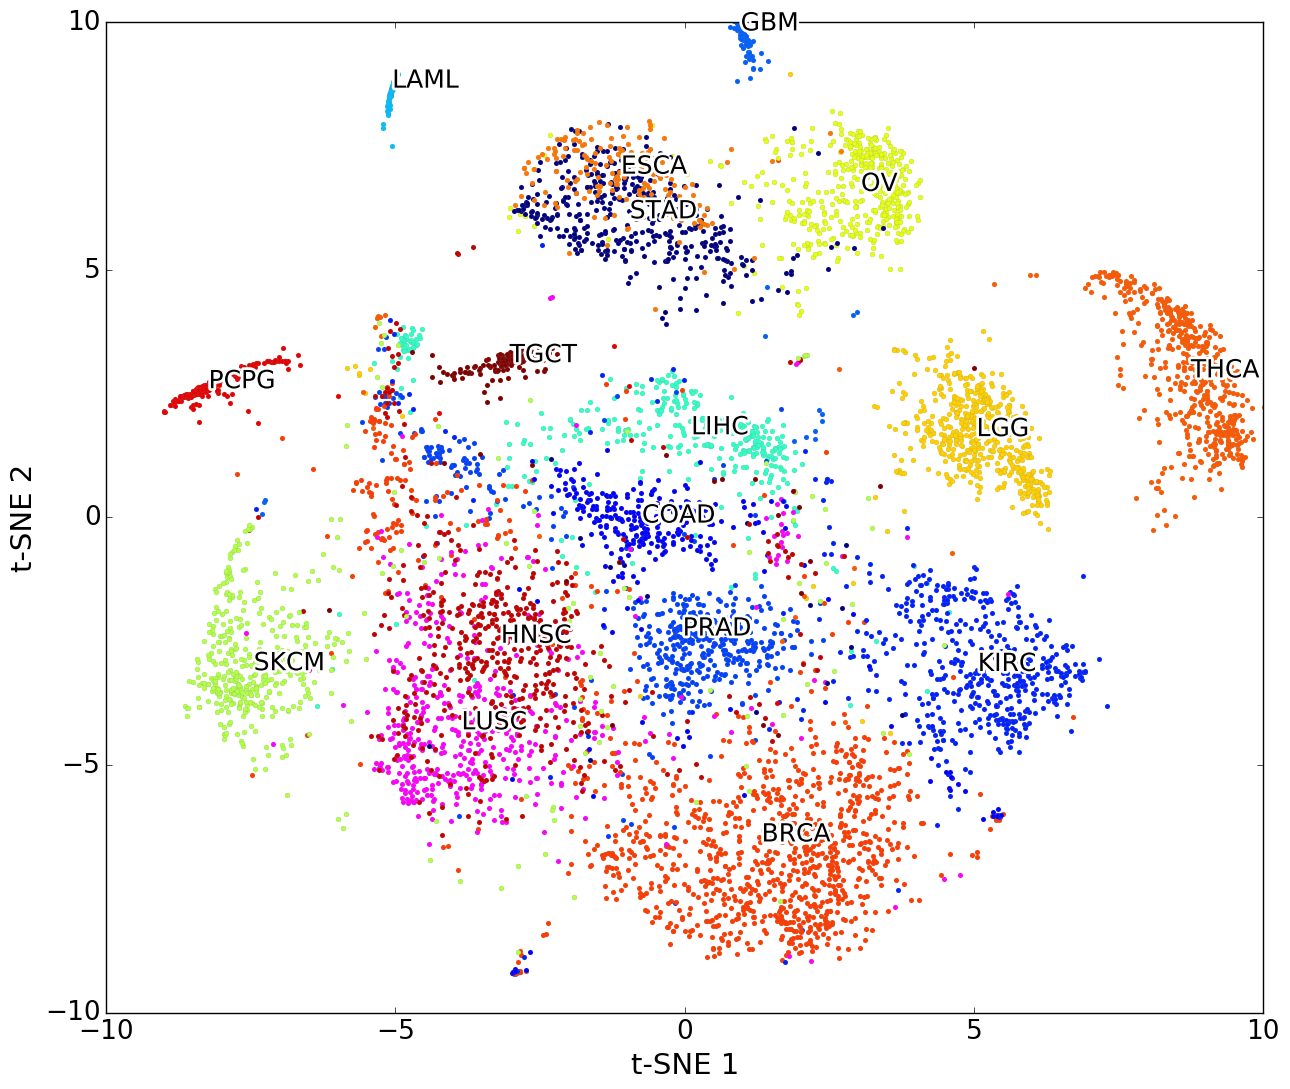

In [36]:
with open('./static/colors_for_33_cancer_types_tsne.pkl', 'rb') as inf:
    colors_dd = pickle.load(inf)

colors_dd['THCA'], colors_dd['OV'] = colors_dd['OV'], colors_dd['THCA']

fig = plt.figure(figsize=(13, 11))
ax = fig.add_subplot(111)


for k, d in enumerate(df_embedded.disease.unique()):
    _df = df_embedded.query('disease == "{0}"'.format(d))
    ax.scatter(_df[0].values, _df[1].values, c=colors_dd[d], s=13, linewidths=0.1, edgecolor='gray', label=d)
    xtxt, ytxt = _df[[0, 1]].median().values
    if d == 'DLBC':
        xtxt += 0.1
        ytxt += 0.2
    txt = ax.text(xtxt, ytxt, d, fontsize=18)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=4, foreground="w", alpha=1),
        PathEffects.Normal()])

# ax.set_title('33 diseases (rs: {0})'.format(random_state))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_xlabel('t-SNE 1', fontsize=21)
ax.set_ylabel('t-SNE 2', fontsize=21)
ax.tick_params(axis='both', which='major', labelsize=19)
# ax.set_title('Visualization of cleavage site profiles in tumor samples', fontsize=20)
plt.tight_layout()

# plt.savefig('../__results/figs/tsne-17-diseases.jpg', dpi=300)

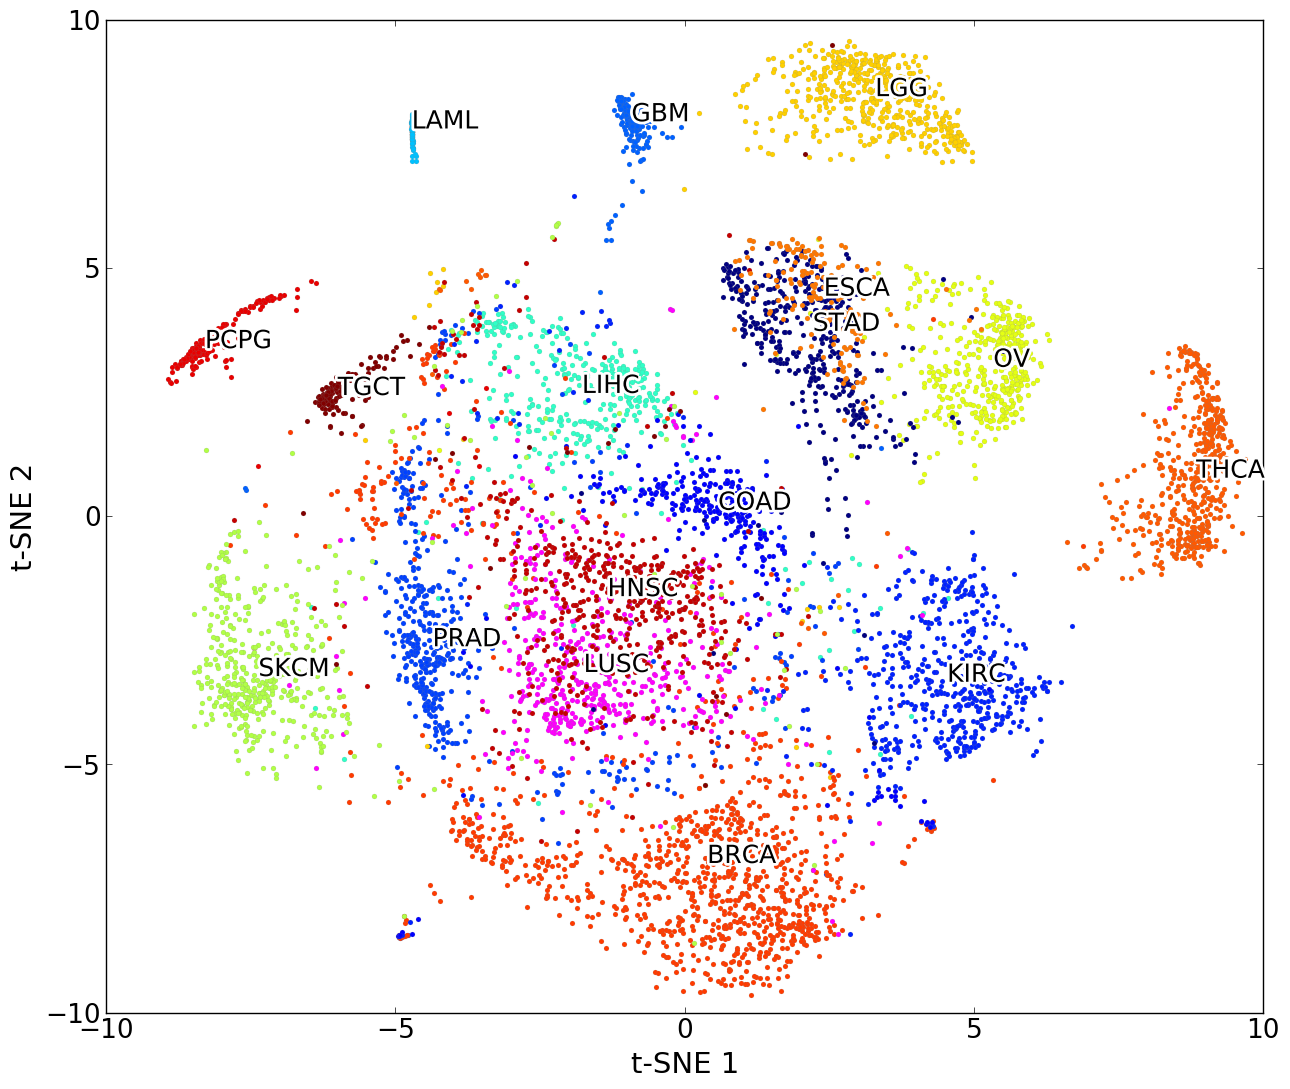

In [43]:
with open('./static/colors_for_33_cancer_types_tsne.pkl', 'rb') as inf:
    colors_dd = pickle.load(inf)

colors_dd['THCA'], colors_dd['OV'] = colors_dd['OV'], colors_dd['THCA']

fig = plt.figure(figsize=(13, 11))
ax = fig.add_subplot(111)


for k, d in enumerate(df_embedded.disease.unique()):
    _df = df_embedded.query('disease == "{0}"'.format(d))
    ax.scatter(_df[0].values, _df[1].values, c=colors_dd[d], s=13, linewidths=0.1, edgecolor='gray', label=d)
    xtxt, ytxt = _df[[0, 1]].median().values
    if d == 'DLBC':
        xtxt += 0.1
        ytxt += 0.2
    txt = ax.text(xtxt, ytxt, d, fontsize=18)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=4, foreground="w", alpha=1),
        PathEffects.Normal()])

# ax.set_title('33 diseases (rs: {0})'.format(random_state))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_xlabel('t-SNE 1', fontsize=21)
ax.set_ylabel('t-SNE 2', fontsize=21)
ax.tick_params(axis='both', which='major', labelsize=19)
# ax.set_title('Visualization of cleavage site profiles in tumor samples', fontsize=20)
plt.tight_layout()

# plt.savefig('../__results/figs/tsne-17-diseases.jpg', dpi=300)

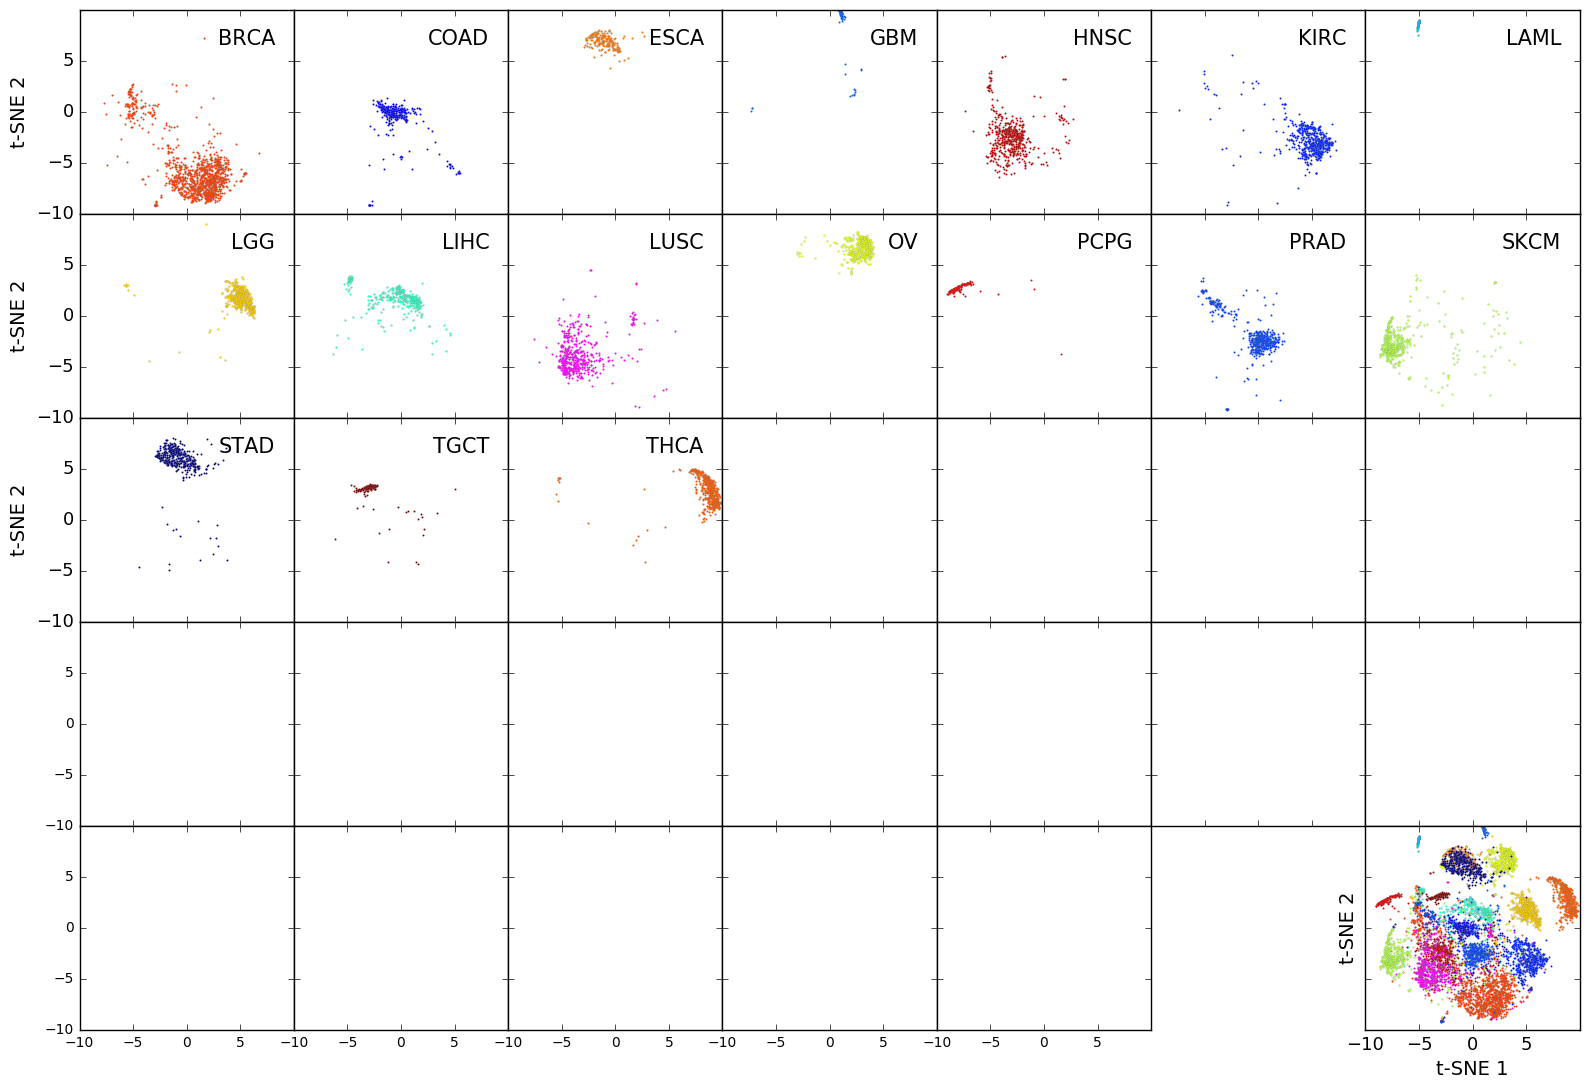

In [42]:
fig, axes = plt.subplots(5, 7, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16, 11))
axes = axes.ravel()

last_ax = axes[-1]
for k, d in enumerate(sorted(df_embedded.disease.unique())):
    ax = axes[k]
    
    _df = df_embedded.query('disease == "{0}"'.format(d))
    for x in [ax, last_ax]:
        x.scatter(_df[0].values, _df[1].values, c=colors_dd[d], s=1.8, linewidths=0.1, edgecolor='gray', label=d)
    
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    # markerscale=0: don't show marker
    ax.legend(loc='best', framealpha=0, markerscale=0, fontsize=15)
    ax.set_xticks(np.arange(-10, 10, 5))
    ax.set_yticks(np.arange(-10, 10, 5))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)

    if k % 7 == 0:
        ax.set_ylabel('t-SNE 2', fontsize=14)
    if k >= 28:
        ax.set_xlabel('t-SNE 1', fontsize=14)
    
# make empty plot all white
axes[-2].patch.set_facecolor('white')
axes[-2].axis('off')
last_ax.tick_params(axis='both', which='major', labelsize=13)
last_ax.set_xlabel('t-SNE 1', fontsize=14)
last_ax.set_ylabel('t-SNE 2', fontsize=14)

fig.tight_layout()

# plt.savefig('../results/figs/tsne-33-diseases-subplots.jpg', dpi=300)